In [6]:
from hypersurface_tf import *
import sympy as sp
from pprint import pprint
from scipy.optimize import minimize
from sympy.utilities.iterables import flatten
import math
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf

In [2]:
z0, z1, z2, z3, z4= sp.symbols('z0, z1, z2, z3, z4')
Z = [z0,z1,z2,z3,z4]
f = z0**5 + z1**5 + z2**5 + z3**5 + z4**5 + 0.5*z0*z1*z2*z3*z4
HS = Hypersurface(Z, f, 1000)

In [3]:
k = 1
HS.set_k(k)

In [9]:
start_time = time.time()
with tf.device('/GPU:0'):
    factor = HS.integrate(lambda patch, h_matrix='identity': 
                                patch.num_eta_tf(h_matrix), tensor=True)
print(time.time()-start_time)

Executing op BatchMatMulV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BatchMatMulV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BatchMatMulV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conj in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RealDiv in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Pow in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatrixDeterminant in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Real in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RealDiv in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Exec

Normalization factor of eta

In [10]:
factor

<tf.Tensor: shape=(), dtype=float64, numpy=0.3429215117088201>

In [6]:
def get_h_matrix(HS, k):
    # Get the power of the coordinates
    sec, ns = HS.get_sections(k)
    h_diag = []
    for expr in sec:
        power = []
        for i in range(len(Z)):
            power.append(expr.diff(Z[i])*Z[i]/expr)
        h_diag.append(power)

    h_matrix = []
    h_params = np.zeros((ns, ns))
    # make a pair for each matrix element
    for i in range(len(h_diag)):
        h_matrix_row = []
        pz = h_diag[i]
        for j in range(len(h_diag)):
            pzbar = h_diag[j]
            #if k >= len(Z):
            for l in range(len(Z)-1):
                if (pz[l]-pzbar[l]-pz[l+1]+pzbar[l+1]) % 5 != 0:
                    h_matrix_row.append([])
                    break
            else:
                h_matrix_row.append([pz,pzbar])
                h_params[i][j] = -1
                    #if (pz!=pzbar):
                    #print( "non-diagonal", pz, pzbar )
            #else:
                #if i == j:
                   # h_matrix_row.append([pz,pzbar])
                   # h_params[i][j] = -1
                #else:
               #     h_matrix_row.append([])
                    
        h_matrix.append(h_matrix_row)                  
    #print( h_matrix[2][2] )
    
    h_type = []
    param = 1
    for i in range(ns):
        for j in range(ns):
            if h_params[i][j] > -1:
                continue
            for m in range(i, ns):
                for n in range(ns):
                    if h_params[m][n] > -1:
                        continue
                    if sorted(h_matrix[m][n][0]) == sorted(h_matrix[i][j][0]):
                        for perm in itertools.permutations(range(5)):
                            if h_matrix[i][j] == [[h_matrix[m][n][0][p] for p in perm],[h_matrix[m][n][1][p] for p in perm]]:
                                h_params[m][n] = param
                                h_params[n][m] = param
                                break
            param += 1
            if i == 0 and j == 0:
                continue
            else:
                h_type.append(i!=j)
            
    return (h_params,h_type)

In [7]:
(h_sym,h_complex) = get_h_matrix(HS, k)
print(h_complex)

[True, False, False, False, False]


In [8]:
h_sym

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 4., 0., 0.],
       [0., 0., 0., ..., 0., 3., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Reconstruct h matrix from the parameters

In [9]:
def number_of_real_parameters(h_complex):
    return sum([2 if x else 1 for x in h_complex])

In [10]:
def param_to_matrix(param):
    h_matrix = np.array(h_sym,dtype='complex')
    i_cpx = len(h_complex)
    for i in range(len(h_complex)):
         if not h_complex[i]:
            x = exp(param[i])
            for m in range(len(h_sym)):
                if h_sym[m][m] == i+2:
                    h_matrix[m][m] = x
                    #print(h_matrix[m][m])
    for i in range(len(h_complex)):
        if h_complex[i]:
            x = exp(complex(-(param[i] - 1)**2, param[i_cpx]))
            for m in range(len(h_sym)):
                for n in range(m,len(h_sym)):
                    if h_sym[m][n] == i+2:
                        # these should all be related by symmetry - check?
                        xn = x * sqrt(h_matrix[m][m]*h_matrix[n][n])
                        h_matrix[m][n] = xn
                        h_matrix[n][m] = np.conj(xn)
                
                        
            i_cpx += 1
    return h_matrix

In [11]:
def integration(param): 
    h = param_to_matrix(param)
    #h = np.matmul(g, np.conj(g.transpose()))
    
    integration = HS.integrate(lambda patch, point, h_matrix=h: 
                                np.absolute(patch.num_eta(h_matrix, point)/factor - 1).real, 
                                holomorphic=True, numerical=True)
    integration = integration.real
    print(HS.integrate(lambda patch, point: patch.num_FS_volume_form(h, point)/patch.num_FS_volume_form('identity', point), numerical=True))
    print(integration)
    print(param)
    try:
        np.linalg.cholesky(h)
    except:
        print("Not positive definite")
    return integration

Set an initial condition

In [12]:
g0 = np.zeros(number_of_real_parameters(h_complex))

In [13]:
g0

array([0., 0., 0., 0., 0., 0.])

In [14]:
h = param_to_matrix(g0)

In [15]:
#res = minimize(integration, g0, method='L-BFGS-B', options={'iprint':1, 'ftol': 1e-04, 'eps': 1e-02, 'maxiter':20})
res = minimize(integration, g0, method='L-BFGS-B', options={'ftol': 1e-06, 'maxiter':200})

1.0049393905399773
0.24961719509700228
[0. 0. 0. 0. 0. 0.]
1.0049393906072692
0.24961719514670996
[1.e-08 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
1.0049393903436923
0.24961719568113325
[0.e+00 1.e-08 0.e+00 0.e+00 0.e+00 0.e+00]
1.0049393904002752
0.24961719527274578
[0.e+00 0.e+00 1.e-08 0.e+00 0.e+00 0.e+00]
1.0049393908393278
0.24961719389275397
[0.e+00 0.e+00 0.e+00 1.e-08 0.e+00 0.e+00]
1.0049393906346313
0.24961719478232966
[0.e+00 0.e+00 0.e+00 0.e+00 1.e-08 0.e+00]
1.0049393905274728
0.24961719508276
[0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-08]
1.0528227175620684
0.2864836179989638
[-0.03583611 -0.42112163 -0.12669999  0.86818717  0.22685914  0.01026778]
1.052822717613389
0.2864836179946637
[-0.0358361  -0.42112163 -0.12669999  0.86818717  0.22685914  0.01026778]
1.0528227173316487
0.28648361737392286
[-0.03583611 -0.42112162 -0.12669999  0.86818717  0.22685914  0.01026778]
1.052822717371388
0.28648361783543685
[-0.03583611 -0.42112163 -0.12669998  0.86818717  0.22685914  0.01026778

1.032243657738881
0.20682258036948054
[-0.26190314 -0.24991083 -1.15398594  0.27533739  0.13126113 -0.00729708]
1.0322436576197282
0.20682258031873788
[-0.26190314 -0.24991083 -1.15398594  0.27533739  0.13126112 -0.00729707]
1.0328886164980442
0.20645336933093977
[-0.34219686 -0.28107123 -1.3597341   0.27515466  0.03432584 -0.0139951 ]
1.0328886165579574
0.20645336933657285
[-0.34219685 -0.28107123 -1.3597341   0.27515466  0.03432584 -0.0139951 ]
1.0328886162136541
0.20645336930090585
[-0.34219686 -0.28107122 -1.3597341   0.27515466  0.03432584 -0.0139951 ]
1.0328886164391728
0.20645336932114025
[-0.34219686 -0.28107123 -1.35973409  0.27515466  0.03432584 -0.0139951 ]
1.032888616909048
0.20645336942897108
[-0.34219686 -0.28107123 -1.3597341   0.27515467  0.03432584 -0.0139951 ]
1.0328886166028242
0.2064533693864117
[-0.34219686 -0.28107123 -1.3597341   0.27515466  0.03432585 -0.0139951 ]
1.0328886164931979
0.20645336933238254
[-0.34219686 -0.28107123 -1.3597341   0.27515466  0.03432584

1.0417211745771284
0.20321382055501117
[-3.07372041 -1.08322556 -7.67179877  0.1885681  -4.01514233 -0.25862733]
1.0417211743720125
0.2032138205640415
[-3.07372042 -1.08322555 -7.67179877  0.1885681  -4.01514233 -0.25862733]
1.0417211745769674
0.20321382055494266
[-3.07372042 -1.08322556 -7.67179876  0.1885681  -4.01514233 -0.25862733]
1.0417211751063884
0.20321382052153691
[-3.07372042 -1.08322556 -7.67179877  0.18856811 -4.01514233 -0.25862733]
1.0417211745795376
0.20321382055587942
[-3.07372042 -1.08322556 -7.67179877  0.1885681  -4.01514232 -0.25862733]
1.0417211745771284
0.20321382055501117
[-3.07372042 -1.08322556 -7.67179877  0.1885681  -4.01514233 -0.25862732]
1.0421823902002798
0.2031748331504041
[-3.3119448  -1.11354893 -8.22564011  0.18686447 -4.36831545 -0.27979996]
1.0421823902002798
0.20317483315040413
[-3.31194479 -1.11354893 -8.22564011  0.18686447 -4.36831545 -0.27979996]
1.042182389998739
0.20317483315106766
[-3.3119448  -1.11354892 -8.22564011  0.18686447 -4.36831545

In [16]:
print(res.x)

[ -6.63209609  -1.15719903 -15.90452336   0.18214517  -9.30861272
  -0.57980386]


In [17]:
h_minimal = param_to_matrix(res.x)

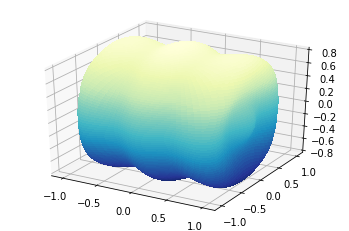

In [18]:
#param = [0.8, 0.8]
param = [-0.13814375, -0.16041894 ,-0.90220166 , 0.3039817 ,  0.08749082 , 0.11340696]
h_minimal = param_to_matrix(param)
#h_minimal = 'identity'
patch = HS.patches[0].patches[0]
theta, phi = np.linspace(0.001,np.pi+0.001, 100), np.linspace(0.001, 2*np.pi+0.001, 100)
R = []
for j in phi:
    theta_list = []
    for i in theta:
        t = complex(math.sin(i)*math.sin(j), math.cos(i))/(sin(i)*cos(j)) 
        if np.absolute(t) <= 1:
            eta = patch.num_eta(h_minimal, [1, -1, complex(t), 0, -complex(t)])/factor 
            #print('test',np.absolute(t**4))
            #print(patch.restriction([1, -1, complex(t), 0, -complex(t)]))
            #print("t<=1", t)
        else:
            #eta = 0
            eta = patch.num_eta(h_minimal, [1, -1, complex(1/t), 0, -complex(1/t)])/factor
  
            #print('test',np.absolute(t**4), 1/t**4)
        theta_list.append(float(eta))
    R.append(theta_list)
R = np.asarray(R)
THETA, PHI = np.meshgrid(theta, phi)
X = R * np.sin(THETA) * np.cos(PHI)
Y = R * np.sin(THETA) * np.sin(PHI)
ZZ = R * np.cos(THETA)
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
ax.set_zlim3d(-0.8, 0.8)
plot = ax.plot_surface(
    X, Y, ZZ, rstride=1, cstride=1, cmap=plt.cm.YlGnBu_r,
    linewidth=0, antialiased=False)


Standard deviation of eta:

In [19]:
sum_eta_sq = 0
mean_abs_eta = 0
for patch in HS.patches:
    for subpatch in patch.patches:
        for point in subpatch.points:
            #print(subpatch.num_eta(h_minimal, point)*factor - 1)
            eta = sum_eta = 0
mean_abs_eta = 0
for patch in HS.patches:
    for subpatch in patch.patches:
        for point in subpatch.points:
            #print(subpatch.num_eta(h_minimal, point)*factor - 1)
            eta = subpatch.num_eta(h_minimal, point)
            sum_eta_sq += (eta/factor - 1)**2
            mean_abs_eta += abs(eta/factor - 1)
print(math.sqrt((sum_eta_sq-mean_abs_eta**2/HS.n_points)/(HS.n_points - 1)))

0.21875651133455828


In [20]:
sigma = HS.integrate(lambda patch, point, h_matrix=h_minimal: 
                         np.absolute(patch.num_eta(h_matrix, point)/factor - 1).real, 
                         holomorphic=True, numerical=True)

In [21]:
delta_sigma = math.sqrt(HS.integrate(lambda patch, point, h_matrix=h_minimal: 
                         (np.absolute(patch.num_eta(h_matrix, point)/factor - 1).real - sigma)**2, 
                         holomorphic=True, numerical=True)/HS.n_points)

In [22]:
print(delta_sigma)

0.002757011281021444


In [23]:
print(sigma)

0.20734764986220483
